## Fourier Shell Correlation
Measures the normalised cross-correlation coefficient between 2 3D volumes over shells in Fourier Space.

$$FSC(r) = \frac{\sum_{r_i \in r} F_1(r_i) \cdot F_2(r_i)^*}{\sqrt{\sum_{r_i \in r} |F_1(r_i)|^2 \cdot \sum_{r_i \in r} |F_2(r_i)|^2}}$$


In [1]:
import torch, mrcfile, numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
denoised_image = mrcfile.read('/Users/HenryJones/Desktop/SULI/cryocare_denoised.mrc')
denoised_tensor = torch.tensor(denoised_image)
mean = torch.zeros_like(denoised_tensor)
std = torch.ones_like(denoised_tensor) * 10

noisy_image = torch.normal(mean = mean, std = std)
noisy_image = noisy_image + denoised_tensor

<class 'numpy.ndarray'> (200, 2000, 2000)
853.1456 -1015.66296


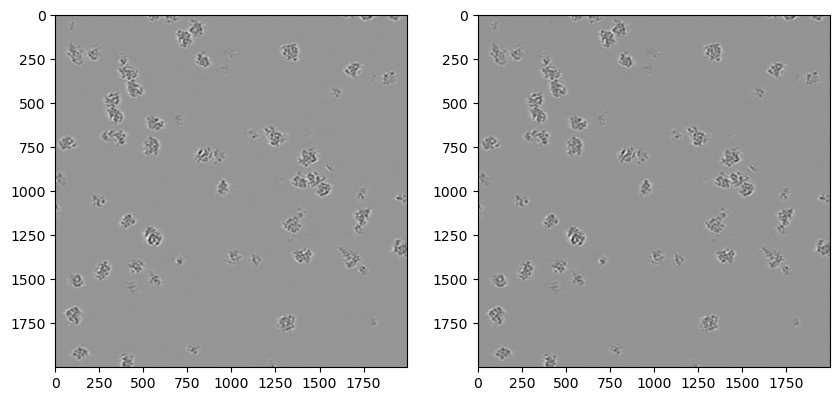

In [3]:
print(type(denoised_image), np.shape(denoised_image))

print(np.max(denoised_image), np.min(denoised_image))
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].imshow(denoised_image[100,:,:], cmap = 'Greys_r')
ax[1].imshow(noisy_image[100,:,:].numpy(), cmap = 'Greys_r')

#plt.colorbar()

# Reals

In [4]:
FT_denoised_r = torch.fft.rfftn(denoised_tensor)
FT_noisy_r = torch.fft.rfftn(noisy_image)

In [5]:
print(FT_denoised_r.shape, FT_noisy_r.shape)

torch.Size([200, 2000, 1001]) torch.Size([200, 2000, 1001])


In [6]:
FT_denoised = torch.fft.fftshift(torch.fft.fftn(denoised_tensor), dim = (-3, -2, -1))
FT_noisy = torch.fft.fftshift(torch.fft.fftn(noisy_image), dim = (-3, -2, -1))

In [7]:
bin_centers = torch.fft.fftfreq(FT_noisy.shape[0])
print(bin_centers.shape, bin_centers[:10], bin_centers[-10:], 1/bin_centers[-10:])

torch.Size([200]) tensor([0.0000, 0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350, 0.0400,
        0.0450]) tensor([-0.0500, -0.0450, -0.0400, -0.0350, -0.0300, -0.0250, -0.0200, -0.0150,
        -0.0100, -0.0050]) tensor([ -20.0000,  -22.2222,  -25.0000,  -28.5714,  -33.3333,  -40.0000,
         -50.0000,  -66.6667, -100.0000, -200.0000])


In [8]:
max_dist = torch.sqrt(torch.tensor((FT_noisy.shape[0]/2)**2 + (FT_noisy.shape[1]/2)**2 + (FT_noisy.shape[2]/2)**2))
bin_interval = 10
bins = torch.arange(0, max_dist + bin_interval, bin_interval)
meshgrid = torch.meshgrid([torch.arange(FT_noisy.shape[0]) - FT_noisy.shape[0]/2,
                                                   torch.arange(FT_noisy.shape[1]) - FT_noisy.shape[1]/2,
                                                   torch.arange(FT_noisy.shape[2]) - FT_noisy.shape[2]/2],
                                                  indexing = 'ij')

freq_radius = torch.sqrt(torch.pow(meshgrid[0],2) + torch.pow(meshgrid[1],2) + torch.pow(meshgrid[2],2))

In [9]:
print(max_dist)

tensor(1417.7446)


In [10]:
print(torch.max(freq_radius))

tensor(1417.7446)


In [11]:
histogram = torch.histogram(freq_radius, bins)

In [12]:
print(bins.shape)

torch.Size([143])


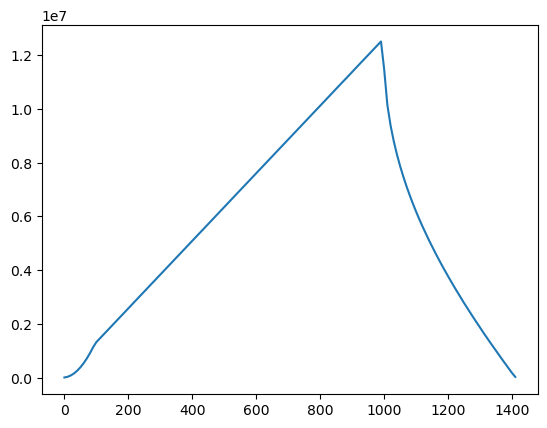

In [13]:
plt.plot(histogram[-1][:-1], histogram[0])

In [14]:
sorted_frequencies, sort_idx = torch.sort(freq_radius, descending = False)

In [15]:
print(sorted_frequencies[-5:,1000,1000])

tensor([508.9450, 509.1326, 509.3221, 509.5135, 509.7068])


In [16]:
sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)

In [17]:
FT_denoised = torch.flatten(FT_denoised)
FT_noisy = torch.flatten(FT_noisy)

In [18]:
print(sorted_frequencies_flat[:10], sort_idx_flat[:5])

tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.4142, 1.4142,
        1.4142]) tensor([402001000, 402001001, 402000999, 398001000, 406001000])


In [19]:
split_idx = torch.searchsorted(sorted_frequencies_flat, bins) #split points are bins

In [20]:
shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #if we don't exlude the last one, we just shape of 144?

In [21]:
print(FT_denoised.shape)

torch.Size([800000000])


In [22]:
del(denoised_image, denoised_tensor, noisy_image, mean, std, freq_radius,
     histogram, FT_denoised_r, FT_noisy_r, sort_idx_flat, sort_idx, 
     sorted_frequencies, sorted_frequencies_flat)

In [23]:
def _normalised_cc_complex_1d(a: torch.Tensor, b:torch.Tensor):
    correlation = torch.dot(a, torch.conj(b))
    return correlation / (torch.linalg.norm(a) * torch.linalg.norm(b))

fsc = torch.real(torch.tensor([
    _normalised_cc_complex_1d(FT_denoised[idx], FT_noisy[idx])
    for idx in shell_index
]))

Text(0.5, 1.0, 'FSC')

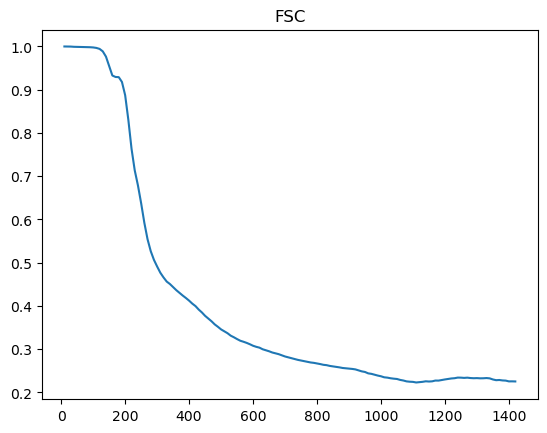

In [25]:
plt.plot(bins, fsc.numpy())
plt.title("FSC")